# Learning to Detect Fake Content on Twitter

## Contents

* The problem
* Data
* Feature Engineering
* Classification
* Results
* Tweet Verification Assistant

## The verification problem

![title](images/problem.png)

## Data

#### Collection
* Set of tweets collected 
    * with a set of keywords & hashtags
    * only those with multimedia content (image/video)
    * derived from 53 events (e.g. Hurricane Sandy, Boston Marathon bombings, Nepal earthquake)

#### Ground truth
* Reputable online resources which debunk images/videos

#### Statistics

10634 fake tweets

7223 real tweets

derived from more than 200 fake images & 200 real images

<img src="images/cats.png" />

### Load and Explore the Data

In [118]:
# import the necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import json
import seaborn as sns
pd.options.display.max_columns = 100

In [119]:
# load the data
data  = pd.read_csv('data/tweets_info.csv')
data['id'] = data['id'].astype(str)
data.shape

(17857, 4)

In [120]:
data.head()

,id,text,event,label
0,324597532548276224,Don't need feds to solve the #bostonbombing wh...,Boston,fake
1,325145334739267584,PIC: Comparison of #Boston suspect Sunil Tripa...,Boston,fake
2,325152091423248385,I'm not completely convinced that it's this Su...,Boston,fake
3,324554646976868352,Brutal lo que se puede conseguir en colaboraci...,Boston,fake
4,324315545572896768,4chan and the bombing. just throwing it out th...,Boston,fake


In [121]:
data['label'].value_counts()

fake    10634
real     7223
Name: label, dtype: int64

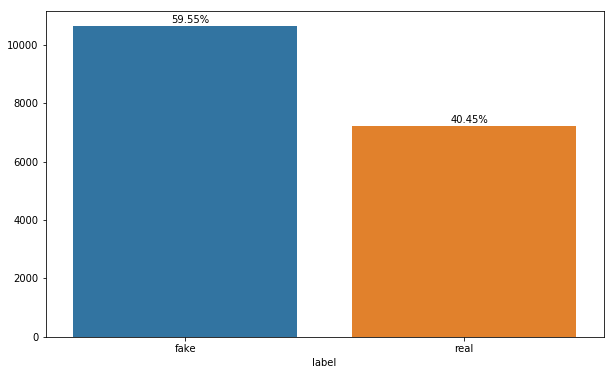

In [122]:
import seaborn as sns

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax = sns.countplot(x='label', data=data)
#ax.set_xticklabels(['No', 'Yes'])

ax.set_xlabel('label')
ax.set_ylabel('')
for p in ax.patches:
    ax.annotate('{:.2f}%'.format(p.get_height()/data.shape[0]*100), (p.get_x()+0.35, p.get_height()+100))

Text(0,0.5,'')

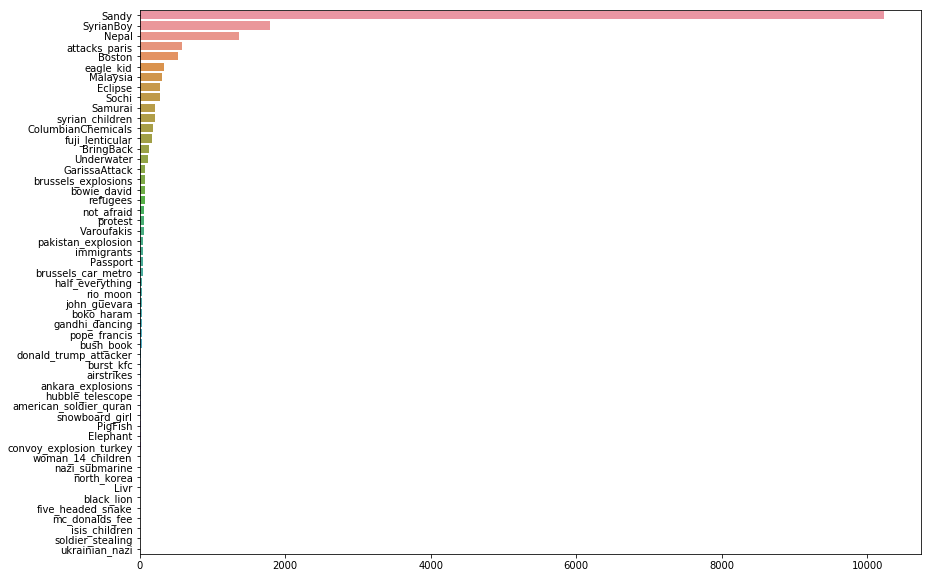

In [123]:
fig, ax = plt.subplots(1, 1, figsize=(14, 10))
ax = sns.countplot(y='event', data=data, order=data['event'].value_counts().index)
#ax.set_xticklabels(['No', 'Yes'])
ax.set_xlabel('')
ax.set_ylabel('')

## Feature Extraction

Features

* Tweet-based 
* User-based

Based on discussions with journalists and they way in which they verify content on the web.

![title](images/feature1.png)

![title2](images/feature2.png)

In [124]:
# load the tweet data
with open('data/tweetsFeatsVMU2016.txt') as f:
    lines = f.readlines()

lines = [json.loads(line) for line in lines]
tweet_data  = pd.DataFrame(lines)
tweet_data.drop(columns=['_id', 'annotation', 
                         'alexaCountryRank', 'alexaDeltaRank', 'alexaPopularity', 'alexaReachRank',
                         'urlHarmonic', 'urlIndegree', 'wotSafe', 'wotTrust'], 
                inplace=True)
tweet_data['id'] = tweet_data['id'].astype(str)
print('Data has {} samples with {} attributes'.format(*tweet_data.shape))

Data has 17857 samples with 25 attributes


In [125]:
tweet_data.head()

,containsExclamationMark,containsFirstOrderPron,containsHappyEmo,containsQuestionMark,containsSadEmo,containsSecondOrderPron,containsThirdOrderPron,hasColon,hasExternalLink,hasPlease,id,itemLength,numExclamationMark,numHashtags,numMentions,numNegSentiWords,numNouns,numPosSentiWords,numQuestionMark,numSlangs,numURLs,numUppercaseChars,numWords,readability,retweetCount
0,False,False,False,True,False,False,True,True,False,False,263046056240115712,134,0,1,0,0.0,NaN,0.0,1,1.0,1,3,25,NaN,0
1,True,False,False,False,False,False,True,True,True,False,262995061304852481,133,2,0,1,0.0,NaN,0.0,0,0.0,1,14,19,NaN,0
2,False,False,False,False,False,False,False,False,False,False,262979898002534400,116,0,2,0,0.0,NaN,0.0,0,1.0,1,5,17,NaN,0
3,False,False,False,False,False,False,False,False,False,False,262996108400271360,46,0,2,0,2.0,1.0,0.0,0,1.0,1,1,4,77.905,0
4,False,False,False,False,False,False,False,False,False,False,263018881839411200,90,0,4,0,0.0,3.0,1.0,0,0.0,1,1,11,116.145,0


In [126]:
# load the user data
with open('data/userFeatsVMU2016.txt') as f:
    lines = f.readlines()

lines = [json.loads(line) for line in lines]
user_data = pd.DataFrame(lines)
user_data.drop(columns=['_id', 'annotation',
                        'alexaCountryRank', 'alexaDeltaRank', 'alexaPopularity', 'alexaReachRank',
                        'harmonic', 'indegree', 'wotTrustUser'], 
               inplace=True)
user_data['id'] = user_data['id'].astype(str)

print('User data has {} samples with {} attributes'.format(*user_data.shape))


User data has 17857 samples with 18 attributes


In [127]:
user_data.head()

,FolFrieRatio,accountAge,hasBio,hasExistingLocation,hasHeaderImg,hasLocation,hasProfileImg,hasURL,id,isVerified,numFavorites,numFollowers,numFriends,numMediaContent,numTweets,timesListed,tweetRatio,username
0,5.833922,1234982831,True,False,False,True,True,False,263046056240115712,False,5243,1651,283,1069,43811,64,32.472860,iAnnieM
1,43.689810,1284854676,True,True,False,True,True,True,262995061304852481,False,45,95637,2189,10400,54293,737,70.346275,CarlosVerareal
2,0.862576,1271108498,True,False,False,True,True,False,262979898002534400,False,274,1701,1972,6455,34414,13,36.970360,LucasPalape
3,0.880150,1295804773,True,False,False,True,True,False,262996108400271360,False,6,235,267,0,17837,0,27.651606,Haaaaarryyy
4,0.937824,1297372694,True,False,False,True,True,False,263018881839411200,False,2867,181,193,1223,25754,0,41.076424,princess__natt


### Check the missing values

In [128]:
features=tweet_data.columns.values
for feature in features:
    print(feature,'- Missing:', 
          sum(tweet_data[feature].isnull()),
          '- Unique:', len(tweet_data[feature].unique()))

containsExclamationMark - Missing: 0 - Unique: 2
containsFirstOrderPron - Missing: 2710 - Unique: 3
containsHappyEmo - Missing: 0 - Unique: 2
containsQuestionMark - Missing: 0 - Unique: 2
containsSadEmo - Missing: 0 - Unique: 2
containsSecondOrderPron - Missing: 2710 - Unique: 3
containsThirdOrderPron - Missing: 2710 - Unique: 3
hasColon - Missing: 0 - Unique: 2
hasExternalLink - Missing: 0 - Unique: 2
hasPlease - Missing: 0 - Unique: 2
id - Missing: 0 - Unique: 17857
itemLength - Missing: 0 - Unique: 128
numExclamationMark - Missing: 0 - Unique: 15
numHashtags - Missing: 0 - Unique: 17
numMentions - Missing: 0 - Unique: 8
numNegSentiWords - Missing: 2710 - Unique: 8
numNouns - Missing: 2603 - Unique: 26
numPosSentiWords - Missing: 2710 - Unique: 8
numQuestionMark - Missing: 0 - Unique: 8
numSlangs - Missing: 2820 - Unique: 11
numURLs - Missing: 0 - Unique: 5
numUppercaseChars - Missing: 0 - Unique: 78
numWords - Missing: 0 - Unique: 34
readability - Missing: 4151 - Unique: 645
retweet

In [129]:
features=user_data.columns.values
for feature in features:
    print(feature,'- Missing:', 
          sum(user_data[feature].isnull()),
          '- Unique:', len(user_data[feature].unique()))

FolFrieRatio - Missing: 0 - Unique: 14427
accountAge - Missing: 0 - Unique: 16838
hasBio - Missing: 0 - Unique: 2
hasExistingLocation - Missing: 0 - Unique: 2
hasHeaderImg - Missing: 0 - Unique: 2
hasLocation - Missing: 0 - Unique: 2
hasProfileImg - Missing: 0 - Unique: 2
hasURL - Missing: 0 - Unique: 2
id - Missing: 0 - Unique: 17857
isVerified - Missing: 0 - Unique: 2
numFavorites - Missing: 0 - Unique: 2943
numFollowers - Missing: 0 - Unique: 3654
numFriends - Missing: 0 - Unique: 2669
numMediaContent - Missing: 0 - Unique: 3313
numTweets - Missing: 0 - Unique: 11004
timesListed - Missing: 0 - Unique: 725
tweetRatio - Missing: 0 - Unique: 17840
username - Missing: 0 - Unique: 16843


#### Number of positive/negative words

Quick check to see what is the nature of the tweets that present no positive sentiment words.

In [130]:
tweet_data.loc[tweet_data['numPosSentiWords'].isna()].head()

,containsExclamationMark,containsFirstOrderPron,containsHappyEmo,containsQuestionMark,containsSadEmo,containsSecondOrderPron,containsThirdOrderPron,hasColon,hasExternalLink,hasPlease,id,itemLength,numExclamationMark,numHashtags,numMentions,numNegSentiWords,numNouns,numPosSentiWords,numQuestionMark,numSlangs,numURLs,numUppercaseChars,numWords,readability,retweetCount
7,False,NaN,False,False,False,NaN,NaN,False,False,False,263111677485142017,69,0,5,0,NaN,4.0,NaN,0,NaN,1,0,5,NaN,0
8,False,NaN,False,False,False,NaN,NaN,False,False,False,262977091983785985,36,0,2,0,NaN,1.0,NaN,0,NaN,1,0,2,NaN,0
10,False,NaN,False,False,False,NaN,NaN,False,False,False,263129115207536640,45,0,3,0,NaN,NaN,NaN,0,NaN,1,0,3,NaN,0
11,False,NaN,False,False,False,NaN,NaN,False,False,False,263091320871063552,66,0,5,0,NaN,1.0,NaN,0,NaN,1,0,5,NaN,0
24,False,NaN,False,False,False,NaN,NaN,False,False,False,263047501433688064,53,0,1,1,NaN,NaN,NaN,0,NaN,1,1,6,NaN,1


Most of them are tweets with lots of hashtags, which were not taken into account while looking for sentiment words. Let's fill the nan values with 0.

In [131]:
tweet_data['numPosSentiWords'].fillna(0, inplace=True)
tweet_data['numNegSentiWords'].fillna(0, inplace=True)
tweet_data['numNouns'].fillna(0, inplace=True)
tweet_data['numSlangs'].fillna(0, inplace=True)
tweet_data['readability'].fillna(0, inplace=True)

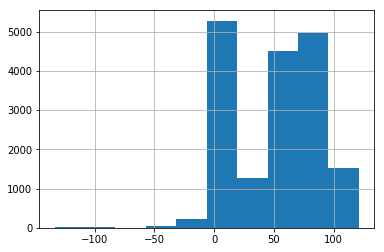

In [132]:
tweet_data['readability'].hist()

### Feature Engineering

#### Merge the features

In [91]:
# add prefix to tweet data
tweet_data = tweet_data.add_prefix('tweet_')
# add prefix to user data
user_data = user_data.add_prefix('user_')
# merge the tweet and user features
features_raw = pd.merge(tweet_data, user_data, left_on='tweet_id', right_on='user_id')
# merge with the info
features_raw = pd.merge(data,features_raw, left_on='id', right_on='tweet_id')

In [92]:
features_raw.head()

,id,text,event,label,tweet_containsExclamationMark,tweet_containsFirstOrderPron,tweet_containsHappyEmo,tweet_containsQuestionMark,tweet_containsSadEmo,tweet_containsSecondOrderPron,tweet_containsThirdOrderPron,tweet_hasColon,tweet_hasExternalLink,tweet_hasPlease,tweet_id,tweet_itemLength,tweet_numExclamationMark,tweet_numHashtags,tweet_numMentions,tweet_numNegSentiWords,tweet_numNouns,tweet_numPosSentiWords,tweet_numQuestionMark,tweet_numSlangs,tweet_numURLs,tweet_numUppercaseChars,tweet_numWords,tweet_readability,tweet_retweetCount,user_FolFrieRatio,user_accountAge,user_hasBio,user_hasExistingLocation,user_hasHeaderImg,user_hasLocation,user_hasProfileImg,user_hasURL,user_id,user_isVerified,user_numFavorites,user_numFollowers,user_numFriends,user_numMediaContent,user_numTweets,user_timesListed,user_tweetRatio,user_username
0,324597532548276224,Don't need feds to solve the #bostonbombing wh...,Boston,fake,True,True,False,False,False,False,False,False,True,False,324597532548276224,88,2,2,0,0.0,2.0,0.0,0,0.0,1,1,13,112.085,0,0.438754,1350475461,True,True,False,True,True,True,324597532548276224,False,168,634,1445,0,903,1,4.953727,SantaCruzShred
1,325145334739267584,PIC: Comparison of #Boston suspect Sunil Tripa...,Boston,fake,False,False,False,False,False,True,True,True,False,False,325145334739267584,135,0,1,0,1.0,7.0,0.0,0,1.0,1,17,18,30.333,0,0.479646,1235638869,True,True,False,True,True,False,325145334739267584,False,879,271,565,133,11972,11,7.913144,Oscar_Wang
2,325152091423248385,I'm not completely convinced that it's this Su...,Boston,fake,False,False,False,False,False,False,False,False,False,False,325152091423248385,88,0,0,0,0.0,2.0,0.0,0,1.0,1,3,13,46.605,0,1.126736,1222220242,True,True,False,True,True,True,325152091423248385,False,22,649,576,762,8313,28,4.983059,jamwil
3,324554646976868352,Brutal lo que se puede conseguir en colaboraci...,Boston,fake,False,False,False,False,False,False,False,False,True,False,324554646976868352,137,0,2,0,1.0,0.0,0.0,0,1.0,1,1,19,0.000,0,0.543956,1306061808,True,False,False,True,True,True,324554646976868352,False,69,297,546,545,2049,4,2.943054,rubenson80
4,324315545572896768,4chan and the bombing. just throwing it out th...,Boston,fake,False,False,False,False,False,False,True,True,False,False,324315545572896768,96,0,0,0,0.0,1.0,0.0,0,1.0,2,0,9,94.300,0,0.983607,1282240608,True,False,False,False,True,False,324315545572896768,False,1,60,61,66,816,0,0.840142,Slimlenny


In [93]:
features_raw.shape

(17857, 47)

In [94]:
# keep the target and binarise
targets = features_raw['label'].map({'fake': 1, 'real': 0})
# keep the event they belong to
events = features_raw['event']
# keep their text
texts = features_raw['text']
# keep the ids
ids = features_raw['id']
# drop columns
features_raw.drop(columns=['tweet_id', 'user_id', 'user_username', 'label', 'event', 'text', 'id'], inplace=True)

In [95]:
features_raw.head()

,tweet_containsExclamationMark,tweet_containsFirstOrderPron,tweet_containsHappyEmo,tweet_containsQuestionMark,tweet_containsSadEmo,tweet_containsSecondOrderPron,tweet_containsThirdOrderPron,tweet_hasColon,tweet_hasExternalLink,tweet_hasPlease,tweet_itemLength,tweet_numExclamationMark,tweet_numHashtags,tweet_numMentions,tweet_numNegSentiWords,tweet_numNouns,tweet_numPosSentiWords,tweet_numQuestionMark,tweet_numSlangs,tweet_numURLs,tweet_numUppercaseChars,tweet_numWords,tweet_readability,tweet_retweetCount,user_FolFrieRatio,user_accountAge,user_hasBio,user_hasExistingLocation,user_hasHeaderImg,user_hasLocation,user_hasProfileImg,user_hasURL,user_isVerified,user_numFavorites,user_numFollowers,user_numFriends,user_numMediaContent,user_numTweets,user_timesListed,user_tweetRatio
0,True,True,False,False,False,False,False,False,True,False,88,2,2,0,0.0,2.0,0.0,0,0.0,1,1,13,112.085,0,0.438754,1350475461,True,True,False,True,True,True,False,168,634,1445,0,903,1,4.953727
1,False,False,False,False,False,True,True,True,False,False,135,0,1,0,1.0,7.0,0.0,0,1.0,1,17,18,30.333,0,0.479646,1235638869,True,True,False,True,True,False,False,879,271,565,133,11972,11,7.913144
2,False,False,False,False,False,False,False,False,False,False,88,0,0,0,0.0,2.0,0.0,0,1.0,1,3,13,46.605,0,1.126736,1222220242,True,True,False,True,True,True,False,22,649,576,762,8313,28,4.983059
3,False,False,False,False,False,False,False,False,True,False,137,0,2,0,1.0,0.0,0.0,0,1.0,1,1,19,0.000,0,0.543956,1306061808,True,False,False,True,True,True,False,69,297,546,545,2049,4,2.943054
4,False,False,False,False,False,False,True,True,False,False,96,0,0,0,0.0,1.0,0.0,0,1.0,2,0,9,94.300,0,0.983607,1282240608,True,False,False,False,True,False,False,1,60,61,66,816,0,0.840142


#### One-hot encoding
Some of our features are categorical, thus we need to apply one-hot encoding to them

In [96]:
cat_cols = []
num_cols = []
for col in features_raw.columns:
    if features_raw[col].dtype==bool or features_raw[col].dtype==object:
        cat_cols.append(col)
    else:
        num_cols.append(col)

In [97]:
features_raw = pd.get_dummies(features_raw, columns=cat_cols)
features_raw.head()

,tweet_itemLength,tweet_numExclamationMark,tweet_numHashtags,tweet_numMentions,tweet_numNegSentiWords,tweet_numNouns,tweet_numPosSentiWords,tweet_numQuestionMark,tweet_numSlangs,tweet_numURLs,tweet_numUppercaseChars,tweet_numWords,tweet_readability,tweet_retweetCount,user_FolFrieRatio,user_accountAge,user_numFavorites,user_numFollowers,user_numFriends,user_numMediaContent,user_numTweets,user_timesListed,user_tweetRatio,tweet_containsExclamationMark_False,tweet_containsExclamationMark_True,tweet_containsFirstOrderPron_False,tweet_containsFirstOrderPron_True,tweet_containsHappyEmo_False,tweet_containsHappyEmo_True,tweet_containsQuestionMark_False,tweet_containsQuestionMark_True,tweet_containsSadEmo_False,tweet_containsSadEmo_True,tweet_containsSecondOrderPron_False,tweet_containsSecondOrderPron_True,tweet_containsThirdOrderPron_False,tweet_containsThirdOrderPron_True,tweet_hasColon_False,tweet_hasColon_True,tweet_hasExternalLink_False,tweet_hasExternalLink_True,tweet_hasPlease_False,tweet_hasPlease_True,user_hasBio_False,user_hasBio_True,user_hasExistingLocation_False,user_hasExistingLocation_True,user_hasHeaderImg_False,user_hasHeaderImg_True,user_hasLocation_False,user_hasLocation_True,user_hasProfileImg_False,user_hasProfileImg_True,user_hasURL_False,user_hasURL_True,user_isVerified_False,user_isVerified_True
0,88,2,2,0,0.0,2.0,0.0,0,0.0,1,1,13,112.085,0,0.438754,1350475461,168,634,1445,0,903,1,4.953727,0,1,0,1,1,0,1,0,1,0,1,0,1,0,1,0,0,1,1,0,0,1,0,1,1,0,0,1,0,1,0,1,1,0
1,135,0,1,0,1.0,7.0,0.0,0,1.0,1,17,18,30.333,0,0.479646,1235638869,879,271,565,133,11972,11,7.913144,1,0,1,0,1,0,1,0,1,0,0,1,0,1,0,1,1,0,1,0,0,1,0,1,1,0,0,1,0,1,1,0,1,0
2,88,0,0,0,0.0,2.0,0.0,0,1.0,1,3,13,46.605,0,1.126736,1222220242,22,649,576,762,8313,28,4.983059,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,1,0,1,1,0,0,1,0,1,0,1,1,0
3,137,0,2,0,1.0,0.0,0.0,0,1.0,1,1,19,0.000,0,0.543956,1306061808,69,297,546,545,2049,4,2.943054,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,1,1,0,0,1,1,0,1,0,0,1,0,1,0,1,1,0
4,96,0,0,0,0.0,1.0,0.0,0,1.0,2,0,9,94.300,0,0.983607,1282240608,1,60,61,66,816,0,0.840142,1,0,1,0,1,0,1,0,1,0,1,0,0,1,0,1,1,0,1,0,0,1,1,0,1,0,1,0,0,1,1,0,1,0


## Classification

In [98]:
targets.value_counts()

1    10634
0     7223
Name: label, dtype: int64

In [99]:
# baseline
accuracy = sum(targets==1) / len(targets)
recall = 1
precision = sum(targets==1) / len(targets) # tp + fp

f_score = 2* (precision*recall) / (precision+recall)

print('Our baseline: Accuracy {:.4f}, F-score {:.4f}'.format(accuracy, f_score))

Our baseline: Accuracy 0.5955, F-score 0.7465


### Splitting into training and testing data

In [100]:
from sklearn.model_selection import train_test_split
random_num = 2
Xtrain, Xtest, ytrain, ytest = train_test_split(features_raw, targets, test_size=0.2, random_state=random_num)
print('Train Shape:', Xtrain.shape)
print('Test Shape:', Xtest.shape)

Train Shape: (14285, 57)
Test Shape: (3572, 57)


### Scaling

In [101]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(Xtrain)

Xtrain = scaler.transform(Xtrain)
Xtest = scaler.transform(Xtest)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  


### Implementation: Cross validation 

In [102]:
from sklearn.model_selection import cross_val_score

def do_cv(predictor, X, y, cv):
    """
    Executes cross validation and display scores
    """
    print('\n### -- ### -- ' + str(type(predictor)).split('.')[-1][:-2] + ' -- ### -- ###')
    cv_score = cross_val_score(predictor, X, y, scoring='f1', cv=cv)
    print ('Mean F1 score after a 10-fold cross validation: ', cv_score.mean())
    print ('F1 score of each fold: ', cv_score)
    return cv_score.mean()

In [103]:
# Helper function to help evaluating the model
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score, precision_score, recall_score
import time

def display_scores(predictor, X, y):
    """
    Calculates metrics and display it
    """
    results = {}
    
    print('\n### -- ### -- ' + str(type(predictor)).split('.')[-1][:-2] + ' -- ### -- ###')
    results['classifier'] = str(type(predictor)).split('.')[-1][:-2]
    # Getting the predicted values
    start = time.time()
    ypred = predictor.predict(X)
    end = time.time()
    results['time_to_predict'] = end-start
    ypred_score = predictor.predict_proba(X)
    
    # calculating metrics
    accuracy = accuracy_score(y, ypred)
    roc = roc_auc_score(y, pd.DataFrame(ypred_score)[1])
    confusion = confusion_matrix(y, ypred)
    fscore = f1_score(y, ypred)
    precision = precision_score(y, ypred)
    recall = recall_score(y, ypred)
    
    print('Confusion Matrix: ', confusion)
    print('Accuracy: ', accuracy)
    print('AUC: ', roc)
    print('recall:', recall)
    print('precision:', precision)
    print('F1-score:', fscore)
    results['fscore'] = fscore
    
    return results
    
    

### Implementation: Choosing a classifier

#### Evaluating with the all the features

In [104]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
import warnings

warnings.filterwarnings("ignore", category=FutureWarning) 

def evaluate(Xtrain, ytrain, Xtest, ytest):
    # Initialize the models
    clf_A = RandomForestClassifier(random_state=0)
    clf_B = LogisticRegression(random_state=0, solver='lbfgs')
    clf_C = GradientBoostingClassifier(random_state=0)
    stats = []
    for learner in [clf_A, clf_B, clf_C]:
        start = time.time()
        learner.fit(Xtrain, ytrain)
        end = time.time()
        train_time = end-start

        fscore_cv = do_cv(learner, Xtrain, ytrain, 10)
        
        # display_scores(learner, Xtrain, ytrain)
        results = display_scores(learner, Xtest, ytest)
        results['train_time'] = train_time
        results['fscore_cv'] = fscore_cv
        
        stats.append(results)
    return stats

In [105]:
results = evaluate(Xtrain, ytrain, Xtest, ytest)
results_all_df = pd.DataFrame(results)
results_all_df.sort_values('time_to_predict', inplace=True)
results_all_df


### -- ### -- RandomForestClassifier -- ### -- ###
Mean F1 score after a 10-fold cross validation:  0.7680246915994389
F1 score of each fold:  [0.78451762 0.7704918  0.75405893 0.76436108 0.75669244 0.7561121
 0.76878944 0.77188803 0.77253731 0.78079815]

### -- ### -- RandomForestClassifier -- ### -- ###
Confusion Matrix:  [[ 989  499]
 [ 508 1576]]
Accuracy:  0.7180851063829787
AUC:  0.7866942255897469
recall: 0.7562380038387716
precision: 0.7595180722891566
F1-score: 0.7578744890598702

### -- ### -- LogisticRegression -- ### -- ###
Mean F1 score after a 10-fold cross validation:  0.7454644195276123
F1 score of each fold:  [0.74343867 0.76282051 0.73723804 0.72255929 0.73329712 0.74959438
 0.74338196 0.76069731 0.75295381 0.7486631 ]

### -- ### -- LogisticRegression -- ### -- ###
Confusion Matrix:  [[ 681  807]
 [ 404 1680]]
Accuracy:  0.6609742441209406
AUC:  0.7188080459414279
recall: 0.8061420345489443
precision: 0.6755126658624849
F1-score: 0.7350689127105667

### -- ### -- Gr

,classifier,fscore,fscore_cv,time_to_predict,train_time
1,LogisticRegression,0.735069,0.745464,0.000268,0.069690
2,GradientBoostingClassifier,0.800000,0.806744,0.005432,2.122745
0,RandomForestClassifier,0.757874,0.768025,0.006597,0.212469


#### Evaluating only with Tweet features

In [106]:
from sklearn.model_selection import train_test_split

tweet_feats_cols = [col for col in features_raw.columns if col.startswith('tweet_')]
Xtrain_tweet, Xtest_tweet, ytrain_tweet, ytest_tweet = train_test_split(
    features_raw[tweet_feats_cols], 
    targets, 
    test_size=0.2, 
    random_state=random_num)
print('Train Shape:', Xtrain_tweet.shape)
print('Test Shape:', Xtest_tweet.shape)

scaler = StandardScaler()
scaler.fit(Xtrain_tweet)

Xtrain_tweet = scaler.transform(Xtrain_tweet)
Xtest_tweet = scaler.transform(Xtest_tweet)

Train Shape: (14285, 34)
Test Shape: (3572, 34)


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  app.launch_new_instance()


In [107]:
results = evaluate(Xtrain_tweet, ytrain_tweet, Xtest_tweet, ytest_tweet)
results_tweet_df = pd.DataFrame(results)
results_tweet_df.sort_values('time_to_predict', inplace=True)
results_tweet_df


### -- ### -- RandomForestClassifier -- ### -- ###
Mean F1 score after a 10-fold cross validation:  0.7875386877199544
F1 score of each fold:  [0.80023095 0.78505747 0.7877719  0.77906977 0.79344646 0.79624193
 0.77608441 0.78066038 0.78525453 0.79156909]

### -- ### -- RandomForestClassifier -- ### -- ###
Confusion Matrix:  [[1046  442]
 [ 421 1663]]
Accuracy:  0.7583986562150056
AUC:  0.8396895251584009
recall: 0.7979846449136276
precision: 0.7900237529691211
F1-score: 0.7939842444497494

### -- ### -- LogisticRegression -- ### -- ###
Mean F1 score after a 10-fold cross validation:  0.7375761562568842
F1 score of each fold:  [0.73549761 0.75647668 0.72833599 0.7257889  0.74066053 0.72813488
 0.73758099 0.74019088 0.74243229 0.74066281]

### -- ### -- LogisticRegression -- ### -- ###
Confusion Matrix:  [[ 643  845]
 [ 383 1701]]
Accuracy:  0.6562150055991042
AUC:  0.7018891051637669
recall: 0.8162188099808061
precision: 0.6681068342498037
F1-score: 0.7347732181425485

### -- ### -- G

,classifier,fscore,fscore_cv,time_to_predict,train_time
1,LogisticRegression,0.734773,0.737576,0.000282,0.095770
2,GradientBoostingClassifier,0.793164,0.803421,0.005052,1.091496
0,RandomForestClassifier,0.793984,0.787539,0.006743,0.121240


#### Evaluating only with User features

In [108]:
from sklearn.model_selection import train_test_split

user_feats_cols = [col for col in features_raw.columns if col.startswith('user_')]
Xtrain_user, Xtest_user, ytrain_user, ytest_user = train_test_split(
    features_raw[user_feats_cols], 
    targets, 
    test_size=0.2, 
    random_state=random_num)
print('Train Shape:', Xtrain_user.shape)
print('Test Shape:', Xtest_user.shape)

scaler = StandardScaler()
scaler.fit(Xtrain_user)

Xtrain = scaler.transform(Xtrain_user)
Xtest = scaler.transform(Xtest_user)

Train Shape: (14285, 23)
Test Shape: (3572, 23)


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  app.launch_new_instance()


In [109]:
results = evaluate(Xtrain_user, ytrain_user, Xtest_user, ytest_user)
results_user_df = pd.DataFrame(results)
results_user_df.sort_values('time_to_predict', inplace=True)
results_user_df


### -- ### -- RandomForestClassifier -- ### -- ###
Mean F1 score after a 10-fold cross validation:  0.6849941292691109
F1 score of each fold:  [0.69194866 0.68430335 0.6958042  0.66942637 0.68281158 0.66868932
 0.68335274 0.69203747 0.6987812  0.68278641]

### -- ### -- RandomForestClassifier -- ### -- ###
Confusion Matrix:  [[ 785  703]
 [ 636 1448]]
Accuracy:  0.6251399776035834
AUC:  0.6580366863248922
recall: 0.6948176583493282
precision: 0.6731752673175267
F1-score: 0.6838252656434475

### -- ### -- LogisticRegression -- ### -- ###
Mean F1 score after a 10-fold cross validation:  0.7488504847755395
F1 score of each fold:  [0.74868651 0.74868651 0.74868651 0.74868651 0.74868651 0.74901445
 0.74901445 0.74901445 0.74901445 0.74901445]

### -- ### -- LogisticRegression -- ### -- ###
Confusion Matrix:  [[   0 1488]
 [   0 2084]]
Accuracy:  0.5834266517357223
AUC:  0.5876545311951789
recall: 1.0
precision: 0.5834266517357223
F1-score: 0.7369165487977369

### -- ### -- GradientBoosting

,classifier,fscore,fscore_cv,time_to_predict,train_time
1,LogisticRegression,0.736917,0.748850,0.000585,0.031576
2,GradientBoostingClassifier,0.743649,0.745902,0.005325,1.202000
0,RandomForestClassifier,0.683825,0.684994,0.007175,0.191308


Let's have a look at the results we have all together.

In [110]:
print('Using all features')
display(results_all_df)
print('Using tweet features')
display(results_tweet_df)
print('Using user features')
display(results_user_df)

Using all features


,classifier,fscore,fscore_cv,time_to_predict,train_time
1,LogisticRegression,0.735069,0.745464,0.000268,0.069690
2,GradientBoostingClassifier,0.800000,0.806744,0.005432,2.122745
0,RandomForestClassifier,0.757874,0.768025,0.006597,0.212469


Using tweet features


,classifier,fscore,fscore_cv,time_to_predict,train_time
1,LogisticRegression,0.734773,0.737576,0.000282,0.095770
2,GradientBoostingClassifier,0.793164,0.803421,0.005052,1.091496
0,RandomForestClassifier,0.793984,0.787539,0.006743,0.121240


Using user features


,classifier,fscore,fscore_cv,time_to_predict,train_time
1,LogisticRegression,0.736917,0.748850,0.000585,0.031576
2,GradientBoostingClassifier,0.743649,0.745902,0.005325,1.202000
0,RandomForestClassifier,0.683825,0.684994,0.007175,0.191308


### Hyperparameter Tuning

In [111]:
# from sklearn.model_selection import GridSearchCV

# param_grid = { 
#     'n_estimators': [100, 200],
#     'max_depth' : [5, 10, 20, 40],
#     'min_samples_leaf' : [7, 10, 15, 20, 30, 50, 90]
# }
# rfc = RandomForestClassifier(random_state=42)
# cv_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=5)
# cv_rfc.fit(Xtrain_tweet, ytrain_tweet)

# print('Best parameters found {} '.format(cv_rfc.best_params_))

### Agreement-based retraining technique

![title2](images/method.png)

In [112]:
import numpy as np
rf_tweet = RandomForestClassifier(max_depth= 20, min_samples_leaf= 7, n_estimators= 200)
rf_user = RandomForestClassifier(max_depth= 20, min_samples_leaf= 7, n_estimators= 200)

rf_tweet.fit(Xtrain_tweet, ytrain_tweet)
preds_tweet = rf_tweet.predict(Xtest_tweet)

rf_user.fit(Xtrain_user, ytrain_user)
preds_user = rf_user.predict(Xtest_user)

print('Length of the test set: {}'.format(len(ytest_tweet)))
# get data where predictions agree
Xagreed = Xtest_tweet[np.where(preds_tweet==preds_user)]
# assume predicted labels are the new groundtruth
yagreed = preds_tweet[np.where(preds_tweet==preds_user)]

print('Classifiers agreed on {} samples or {:.2f}% of the samples'
      .format(
          np.sum(preds_tweet==preds_user), 
          np.sum(preds_tweet==preds_user)/len(preds_tweet)*100
      ))
print('Classifiers disagreed on {} samples or {:.2f}% of the samples'
      .format(
          np.sum(preds_tweet!=preds_user), 
          np.sum(preds_tweet!=preds_user)/len(preds_tweet)*100
      ))

yagreed_original_groundtruth = np.array(ytest_tweet)[np.where(preds_tweet==preds_user)]
print('The length of original {}'.format(len(yagreed_original_groundtruth)))
print('The length of the new {}'.format(len(yagreed)))

fscore = f1_score(yagreed_original_groundtruth, yagreed)
precision = precision_score(yagreed_original_groundtruth, yagreed)
recall = recall_score(yagreed_original_groundtruth, yagreed)
print('F-score of the agreed samples {}'.format(fscore))

# re-train the classifier on the new agreed samples
rf_new = RandomForestClassifier(random_state=0)
rf_new.fit(Xagreed, yagreed)

# get data where predictions don't agree
Xdisagreed = Xtest_tweet[np.where(preds_tweet!=preds_user)]
ydisagreed = np.array(ytest_tweet)[np.where(preds_tweet!=preds_user)]

disagreed_preds = rf_new.predict(Xdisagreed)
fscore_disagreed = f1_score(disagreed_preds, ydisagreed)
print('F-score of the disagreed samples {:.3f}'.format(fscore_disagreed))

print('Overall F-score: {:.3f}'.format(
(np.sum(preds_tweet==preds_user)/len(preds_tweet))*fscore + 
    (np.sum(preds_tweet!=preds_user)/len(preds_tweet))*fscore_disagreed
))
#display_scores(rf_new, Xdisagreed, ydisagreed)

Length of the test set: 3572
Classifiers agreed on 2462 samples or 68.92% of the samples
Classifiers disagreed on 1110 samples or 31.08% of the samples
The length of original 2462
The length of the new 2462
F-score of the agreed samples 0.8667032364234778
F-score of the disagreed samples 0.615
Overall F-score: 0.789


### Checking the feature importances

In [113]:
tweet_feats_importances = pd.DataFrame(sorted(zip(rf_tweet.feature_importances_, tweet_feats_cols),
                                              reverse=True)).rename(columns={0: 'importance', 1:'tweet_feature'})
tweet_feats_importances.head(5)

,importance,tweet_feature
0,0.119081,tweet_readability
1,0.112278,tweet_numUppercaseChars
2,0.098224,tweet_numHashtags
3,0.093830,tweet_itemLength
4,0.078282,tweet_numNouns


In [114]:
user_feats_importances = pd.DataFrame(sorted(zip(rf_user.feature_importances_, user_feats_cols),
                                              reverse=True)).rename(columns={0: 'importance', 1:'user_feature'})
user_feats_importances.head(5)

,importance,user_feature
0,0.142696,user_accountAge
1,0.135381,user_timesListed
2,0.102669,user_tweetRatio
3,0.101706,user_numTweets
4,0.101335,user_numFollowers
